# Wine quality analysis - Machine Learning - PART 4
### Balancing Good / Bad wine in a dataset

Datasource: https://archive.ics.uci.edu/ml/datasets/wine+quality

## Columns description


Column Position | Atrribute Name | Definition 
 --- | --- | --- 
1 | fixed acidity | most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
2 | volatile acidity | the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
3 | citric acid | found in small quantities, citric acid can add 'freshness' and flavor to wines
4 | residual sugar | the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet
5 | chlorides | the amount of salt in the wine
6 | free sulfur dioxidet | he free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine
7 | total sulfur dioxide | amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine
8 | density | the density of water is close to that of water depending on the percent alcohol and sugar content
9 | pH | describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale
10 | sulphates | a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant
11 | alcohol | the percent alcohol content of the wine
12 | quality | output variable (based on sensory data, score between 0 and 10)
13 | good | binary evaluation 1 - good , 0 - bad
14 | color | wine type red or white

# Project Plan 

Import libraries <br/>
Data preparation for machine learning<br/>
Balancing good/bad wine in a dataset<br/>

Random Forest Binary Classification<br/>
Decision Tree Binary Classification<br/>


# Import libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import numpy as np

#import stats libraries 
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pyspark.sql import SparkSession

In [2]:
# May take a little while on a local computer
spark = SparkSession.builder.appName("winequality").getOrCreate()

In [3]:
df = spark.read.csv("winequality.csv",header=True,inferSchema=True)

In [4]:
#df.show(n=2, truncate=False, vertical=True)
df.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0,red


In [5]:
#Create DF for red and white wine
df_red = df.filter(df.color =='red')
df_white = df.filter(df.color =='white')

In [6]:
#create lists of categorical and numberical columns

cat = [item[0] for item in df.dtypes if item[1].startswith('string') ]
num = [item for item in df.columns if item not in cat]
print(cat)
print(num)

['color']
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'good']


# Balancing dataset

### Red wine

In [48]:
df_red_good = df_red[df_red['good'] == 1]
df_red_bad = df_red[df_red['good'] == 0]

red_ratio = round(df_red_good.count()/df_red_bad.count(),2)
print('Good/bad ratio',red_ratio)
print('Good count',df_red_good.count())
print('Bad count',df_red_bad.count())

Good/bad ratio 0.16
Good count 217
Bad count 1382


In [49]:
#sample without replacement bad to match good size, and seed for reproduce the result
df_red_bad = df_red_bad.sample(False, red_ratio, 42)
print('Bad count after sampling',df_red_bad.count())
red_balanced = df_red_good.union(df_red_bad)
print('Balaced count after union',red_balanced.count())

Bad count after sampling 228
Balaced count after union 445


In [50]:
print('Percent of original dataset',round(red_balanced.count()/df_red.count(),2))

Percent of original dataset 0.28


### White wine

In [51]:
df_white_good = df_white[df_white['good'] == 1]
df_white_bad = df_white[df_white['good'] == 0]

white_ratio = round(df_white_good.count()/df_white_bad.count(),2)
print('Good/bad ratio',white_ratio)
print('Good count',df_white_good.count())
print('Bad count',df_white_bad.count())

Good/bad ratio 0.28
Good count 1060
Bad count 3838


In [52]:
#sample without replacement bad to match good size, and seed for reproduce the result
df_white_bad = df_white_bad.sample(False, white_ratio, 42)
print('Bad count after sampling',df_white_bad.count())
white_balanced = df_white_good.union(df_white_bad)
print('Balaced count after union',white_balanced.count())

Bad count after sampling 1103
Balaced count after union 2163


In [53]:
print('Percent of original dataset',round(white_balanced.count()/df_white.count(),2))

Percent of original dataset 0.44


In [54]:
white_balanced

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int, good: int, color: string]

In [55]:
#Match dataframes with balanced values
df = red_balanced.union(white_balanced)
df_red = red_balanced
df_white = white_balanced

# Data preparation for ML

In [ ]:
#Import libraries
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

### Encode wine color

In [59]:
cat

['color']

In [60]:
#convert cat data into INT

#define a list of stages in your pipeline. The string indexer will be one stage
stages = []

#iterate through all categorical values
for categoricalCol in cat:
    #create a string indexer for those categorical values and assign a new name including the word 'Index'
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')

    #append the string Indexer to our list of stages
    stages += [stringIndexer]

#Create the pipeline. Assign the satges list to the pipeline key word stages
pipeline = Pipeline(stages = stages)
#fit the pipeline to our dataframe
pipelineModel = pipeline.fit(df)
#transform the dataframe
df_enc= pipelineModel.transform(df)

In [61]:
num_enc = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'colorIndex']
num_enc

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'colorIndex']

### Create input vector and split data

In [62]:
#create input vector
features_column = num_enc

assembler = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

finalPrep = assembler.transform(df_enc)
finalPrep.show(n=1, truncate=False, vertical=True)

-RECORD 0----------------------------------------------------------------------------
 fixed acidity        | 7.3                                                          
 volatile acidity     | 0.65                                                         
 citric acid          | 0.0                                                          
 residual sugar       | 1.2                                                          
 chlorides            | 0.065                                                        
 free sulfur dioxide  | 15.0                                                         
 total sulfur dioxide | 21.0                                                         
 density              | 0.9946                                                       
 pH                   | 3.39                                                         
 sulphates            | 0.47                                                         
 alcohol              | 10.0                          

In [63]:
#split in training and testing datasets
training_enc, test_enc = finalPrep.randomSplit([0.7, 0.3])
# Going to cache the data  
training_enc.cache()
test_enc.cache()
print(training_enc.count())
print(test_enc.count())

1814
794


### Data preparation for machine learning - Red only

In [64]:
#create input vector
features_column = num[0:-2]

assembler_red = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

finalPrep_red = assembler_red.transform(df_red)
#finalPrep_red.show(n=1, truncate=False, vertical=True)
finalPrep_red.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color,features
0,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,1,red,"[7.3, 0.65, 0.0, 1.2, 0.065, 15.0, 21.0, 0.994..."
1,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,1,red,"[7.8, 0.58, 0.02, 2.0, 0.073, 9.0, 18.0, 0.996..."
2,8.5,0.28,0.56,1.8,0.092,35.0,103.0,0.9969,3.30,0.75,10.5,7,1,red,"[8.5, 0.28, 0.56, 1.8, 0.092, 35.0, 103.0, 0.9..."
3,8.1,0.38,0.28,2.1,0.066,13.0,30.0,0.9968,3.23,0.73,9.7,7,1,red,"[8.1, 0.38, 0.28, 2.1, 0.066, 13.0, 30.0, 0.99..."
4,7.5,0.52,0.16,1.9,0.085,12.0,35.0,0.9968,3.38,0.62,9.5,7,1,red,"[7.5, 0.52, 0.16, 1.9, 0.085, 12.0, 35.0, 0.99..."


In [65]:
#split in training and testing datasets
training_red, test_red = finalPrep_red.randomSplit([0.7, 0.3])
# Going to cache the data  
training_red.cache()
test_red.cache()
print(training_red.count())
print(test_red.count())

322
123


### Data preparation for machine learning - White only

In [66]:
#create input vector
features_column = num[0:-2]

assembler_white = (VectorAssembler()
  .setInputCols(features_column)
  .setOutputCol("features"))

finalPrep_white = assembler_red.transform(df_white)
#finalPrep_red.show(n=1, truncate=False, vertical=True)
finalPrep_white.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,good,color,features
0,6.6,0.16,0.40,1.5,0.044,48.0,143.0,0.9912,3.54,0.52,12.4,7,1,white,"[6.6, 0.16, 0.4, 1.5, 0.044, 48.0, 143.0, 0.99..."
1,6.6,0.17,0.38,1.5,0.032,28.0,112.0,0.9914,3.25,0.55,11.4,7,1,white,"[6.6, 0.17, 0.38, 1.5, 0.032, 28.0, 112.0, 0.9..."
2,6.2,0.66,0.48,1.2,0.029,29.0,75.0,0.9892,3.33,0.39,12.8,8,1,white,"[6.2, 0.66, 0.48, 1.2, 0.029, 29.0, 75.0, 0.98..."
3,6.2,0.66,0.48,1.2,0.029,29.0,75.0,0.9892,3.33,0.39,12.8,8,1,white,"[6.2, 0.66, 0.48, 1.2, 0.029, 29.0, 75.0, 0.98..."
4,6.4,0.31,0.38,2.9,0.038,19.0,102.0,0.9912,3.17,0.35,11.0,7,1,white,"[6.4, 0.31, 0.38, 2.9, 0.038, 19.0, 102.0, 0.9..."


In [67]:
#split in training and testing datasets
training_white, test_white = finalPrep_white.randomSplit([0.7, 0.3])
# Going to cache the data  
training_white.cache()
test_white.cache()
print(training_white.count())
print(test_white.count())

1543
620


# Random Forest Binary Classification 

In [68]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.evaluation import BinaryClassificationEvaluator
import sklearn 
from sklearn.metrics import classification_report, confusion_matrix

In [69]:
def RFClassifer(training, test):
    rfModel = (RandomForestClassifier()
      .setLabelCol("good")
      .setFeaturesCol("features"))
    paramGrid = (ParamGridBuilder()
      .addGrid(rfModel.maxDepth, [5, 10])
      .addGrid(rfModel.numTrees, [20, 60])
      .build())

    stages = [rfModel]
    pipeline = Pipeline().setStages(stages)
    
    cv = (CrossValidator() # you can feel free to change the number of folds used in cross validation as well
      .setEstimator(pipeline) # the estimator can also just be an individual model rather than a pipeline
      .setEstimatorParamMaps(paramGrid)
      .setEvaluator(BinaryClassificationEvaluator().setLabelCol("good")))
    
    pipelineFitted = cv.fit(training)
    
    print("The Best Parameters:\n--------------------")
    print(pipelineFitted.bestModel.stages[0])      
    pipelineFitted.bestModel.stages[0].extractParamMap()
    
    test_predict = pipelineFitted.bestModel.transform(test).selectExpr("double(round(prediction)) as prediction","double(round(good)) as good")
    display(test_predict.show(3))
    
    return test_predict

In [70]:
def ConfMatrix(test_predict):
        #collect prediction and true value
    y_true = test_predict.select(['good']).collect()
    y_pred = test_predict.select(['prediction']).collect()

    #classification report
    print(classification_report(y_true, y_pred))
    
    #confusion matrix 

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

In [71]:
def Evaluation(test_predict):
    acc = test_predict.selectExpr("prediction", "good",
                        """
                        CASE prediction = good
                        WHEN true then 1
                        ELSE 0
                        END as equal
                        """)
        
    print(acc.selectExpr("sum(equal)/sum(1)").show())

    # Another way to evaluate error
    evaluator = MulticlassClassificationEvaluator(labelCol="good", predictionCol="prediction", metricName="accuracy")
    
    accuracy = evaluator.evaluate(test_predict)
    print("Test Error = %g" % (1.0 - accuracy))
    
    ConfMatrix(test_predict)

### Random Forest Classification - All wine

The Best Parameters:
--------------------
RandomForestClassificationModel: uid=RandomForestClassifier_4302bf837437, numTrees=60, numClasses=2, numFeatures=12
+----------+----+
|prediction|good|
+----------+----+
|       1.0| 1.0|
|       1.0| 1.0|
|       1.0| 1.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.7896725440806045|
+---------------------+

None
Test Error = 0.210327
              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79       404
         1.0       0.78      0.80      0.79       390

    accuracy                           0.79       794
   macro avg       0.79      0.79      0.79       794
weighted avg       0.79      0.79      0.79       794



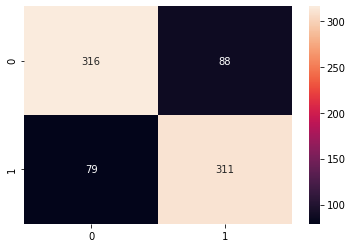

In [72]:
test_predict = RFClassifer(training_enc, test_enc)
Evaluation(test_predict)

### Random Forest Classification - Red Wine only

The Best Parameters:
--------------------
RandomForestClassificationModel: uid=RandomForestClassifier_7de30802b305, numTrees=60, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       1.0| 1.0|
|       1.0| 1.0|
|       1.0| 1.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8292682926829268|
+---------------------+

None
Test Error = 0.170732
              precision    recall  f1-score   support

         0.0       0.87      0.80      0.83        66
         1.0       0.79      0.86      0.82        57

    accuracy                           0.83       123
   macro avg       0.83      0.83      0.83       123
weighted avg       0.83      0.83      0.83       123



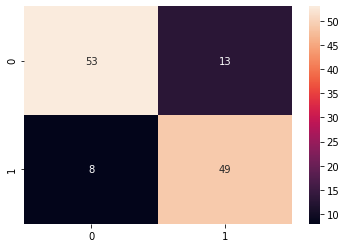

In [73]:
test_predict = RFClassifer(training_red, test_red)
Evaluation(test_predict)

### Random Forest Classification - White Wine only

The Best Parameters:
--------------------
RandomForestClassificationModel: uid=RandomForestClassifier_0ece3e38fdfe, numTrees=60, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       1.0| 1.0|
|       1.0| 1.0|
|       0.0| 1.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.8016129032258065|
+---------------------+

None
Test Error = 0.198387
              precision    recall  f1-score   support

         0.0       0.85      0.75      0.80       321
         1.0       0.76      0.86      0.81       299

    accuracy                           0.80       620
   macro avg       0.81      0.80      0.80       620
weighted avg       0.81      0.80      0.80       620



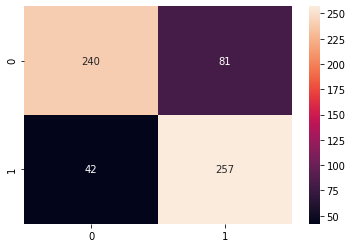

In [74]:
test_predict = RFClassifer(training_white, test_white)
Evaluation(test_predict)

# Decision tree classifier

In [75]:
from pyspark.ml.classification import DecisionTreeClassifier

In [76]:
print(DecisionTreeClassifier().explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)
labelCol: label column name. (default: label)
leafCol: Leaf indices column name. Predicted leaf index of each instance in each tree by preorder. (default: )
maxBins: Max number of bins for discretizing continuous features.  Must be 

In [77]:
def DTClassifer(training, test):
    rfModel = (DecisionTreeClassifier()
      .setLabelCol("good")
      .setFeaturesCol("features"))
    paramGrid = (ParamGridBuilder()
      .addGrid(rfModel.maxDepth, [5, 10, 20])
      .build())

    stages = [rfModel]
    pipeline = Pipeline().setStages(stages)
    
    cv = (CrossValidator() # you can feel free to change the number of folds used in cross validation as well
      .setEstimator(pipeline) # the estimator can also just be an individual model rather than a pipeline
      .setEstimatorParamMaps(paramGrid)
      .setEvaluator(BinaryClassificationEvaluator().setLabelCol("good")))
    
    pipelineFitted = cv.fit(training)
    
    print("The Best Parameters:\n--------------------")
    print(pipelineFitted.bestModel.stages[0])      
    pipelineFitted.bestModel.stages[0].extractParamMap()
    
    test_predict = pipelineFitted.bestModel.transform(test).selectExpr("double(round(prediction)) as prediction","double(round(good)) as good")
    display(test_predict.show(3))
    
    return test_predict

### Decision tree classifier - all wine

The Best Parameters:
--------------------
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_a34b44574b6d, depth=10, numNodes=369, numClasses=2, numFeatures=12
+----------+----+
|prediction|good|
+----------+----+
|       1.0| 1.0|
|       1.0| 1.0|
|       1.0| 1.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.7304785894206549|
+---------------------+

None
Test Error = 0.269521
              precision    recall  f1-score   support

         0.0       0.74      0.73      0.73       404
         1.0       0.72      0.74      0.73       390

    accuracy                           0.73       794
   macro avg       0.73      0.73      0.73       794
weighted avg       0.73      0.73      0.73       794



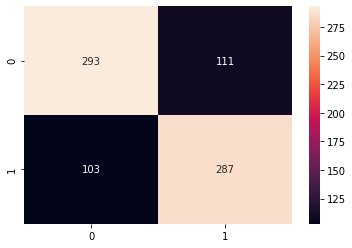

In [79]:
test_predict = DTClassifer(training_enc, test_enc)
Evaluation(test_predict)

### Decision tree classifier - red wine

The Best Parameters:
--------------------
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_4b3f2675f811, depth=5, numNodes=39, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       1.0| 1.0|
|       1.0| 1.0|
|       1.0| 1.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.6991869918699187|
+---------------------+

None
Test Error = 0.300813
              precision    recall  f1-score   support

         0.0       0.75      0.65      0.70        66
         1.0       0.65      0.75      0.70        57

    accuracy                           0.70       123
   macro avg       0.70      0.70      0.70       123
weighted avg       0.71      0.70      0.70       123



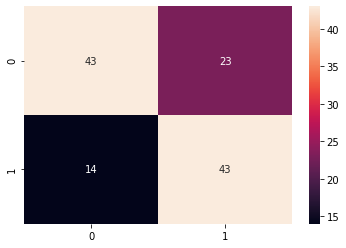

In [80]:
test_predict = DTClassifer(training_red, test_red)
Evaluation(test_predict)

### Decision tree classifier - white wine

The Best Parameters:
--------------------
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_a69874997549, depth=10, numNodes=369, numClasses=2, numFeatures=11
+----------+----+
|prediction|good|
+----------+----+
|       1.0| 1.0|
|       1.0| 1.0|
|       1.0| 1.0|
+----------+----+
only showing top 3 rows



None

+---------------------+
|(sum(equal) / sum(1))|
+---------------------+
|   0.7306451612903225|
+---------------------+

None
Test Error = 0.269355
              precision    recall  f1-score   support

         0.0       0.79      0.66      0.72       321
         1.0       0.69      0.81      0.74       299

    accuracy                           0.73       620
   macro avg       0.74      0.73      0.73       620
weighted avg       0.74      0.73      0.73       620



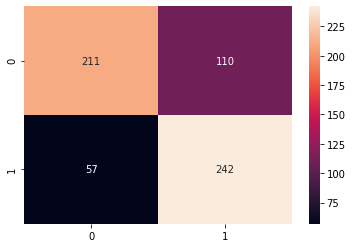

In [81]:
test_predict = DTClassifer(training_white, test_white)
Evaluation(test_predict)